In [4]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [5]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [6]:
import os

data_path = "data/features/genimage-512x512/standard"
suffix = "features/extraction_params/train/features_RGB.csv"
biggan_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan", suffix), index_col=0)
vqdm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm", suffix), index_col=0)
sdv5_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5", suffix), index_col=0)
wukong_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong", suffix), index_col=0)
adm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm", suffix), index_col=0)
glide_train = pd.read_csv(os.path.join(data_path, "imagenet_glide", suffix), index_col=0)
midjourney_train = pd.read_csv(os.path.join(data_path, "imagenet_midjourney", suffix), index_col=0)
mid_sd = pd.concat([sdv5_train, midjourney_train])
combined_train = pd.concat([biggan_train, vqdm_train, sdv5_train, wukong_train, adm_train, glide_train, midjourney_train])

datasets_train = {
    "biggan": biggan_train,
    "vqdm": vqdm_train,
    "sdv5": sdv5_train,
    "wukong": wukong_train,
    "adm": adm_train,
    "glide": glide_train,
    "midjourney": midjourney_train,
    "mid_sd": mid_sd,
    "combined": combined_train,
}

In [7]:
suffix = "features/extraction_params/val/features_RGB.csv"
biggan_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan", suffix), index_col=0)
vqdm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm", suffix), index_col=0)
sdv5_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5", suffix), index_col=0)
wukong_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong", suffix), index_col=0)
adm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm", suffix), index_col=0)
glide_test = pd.read_csv(os.path.join(data_path, "imagenet_glide", suffix), index_col=0)
midjourney_test = pd.read_csv(os.path.join(data_path, "imagenet_midjourney", suffix), index_col=0)
mid_sd = pd.concat([sdv5_test, midjourney_test])
combined_test = pd.concat([biggan_test, vqdm_test, sdv5_test, wukong_test, adm_test, glide_test, midjourney_test])

datasets_test = {
    "biggan": biggan_test,
    "vqdm": vqdm_test,
    "sdv5": sdv5_test,
    "wukong": wukong_test,
    "adm": adm_test,
    "glide": glide_test,
    "midjourney": midjourney_test,
    "mid_sd": mid_sd,
    "combined": combined_test,
}

## Data preparation

In [8]:
def drop_columns(df, drop_only_diagnostic=False):
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            df.drop(column, axis=1, inplace=True)
        elif 'diagnostics' in column:
            df.drop(column, axis=1, inplace=True)
        elif 'Mask' in column:
            df.drop(column, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [9]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

Rows with NaN values:
495    006_biggan_00182.png
662    107_biggan_00008.png
Name: Image, dtype: object
Rows with NaN values:
495    006_biggan_00182.png
662    107_biggan_00008.png
Name: Image, dtype: object


### Split into train and test set

In [10]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}

y_train = {}
y_val = {}

Image_train = {}
Image_val = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)

### Scale the data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in datasets_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in datasets_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        HistGradientBoostingClassifier(random_state=SEED),
        LinearDiscriminantAnalysis(),
        RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED)
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: biggan

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: vqdm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sdv5

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9996875
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9990625


Training set: wukong

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9996875


Training set: adm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.995625


Training set: mid_sd

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.99890625
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9925


Training set: combined

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.997053308331101
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9911152781498348
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9767389945530851


## Evaluation

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [14]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on biggan. ***


Validation set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.9988
F1: 0.9988
Precision: 0.9988
Recall: 0.9988
MCC: 0.9975

Model: LinearDiscriminantAnalysis
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: RandomForestClassifier
Accuracy: 0.9962
F1: 0.9963
Precision: 0.9963
Recall: 0.9962
MCC: 0.9925

Model: LinearSVC
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950


Validation set: vqdm

Model: HistGradientBoostingClassifier
Accuracy: 0.6038
F1: 0.5299
Precision: 0.7789
Recall: 0.6038
MCC: 0.3402

Model: LinearDiscriminantAnalysis
Accuracy: 0.6112
F1: 0.5441
Precision: 0.7707
Recall: 0.6112
MCC: 0.3471

Model: RandomForestClassifier
Accuracy: 0.6188
F1: 0.5539
Precision: 0.7837
Recall: 0.6188
MCC: 0.3671

Model: LinearSVC
Accuracy: 0.6375
F1: 0.5827
Precision: 0.7899
Recall: 0.6375
MCC: 0.3993


Validation set: sdv5



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5012
F1: 0.3383
Precision: 0.5836
Recall: 0.5012
MCC: 0.0205



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5088
F1: 0.3587
Precision: 0.6368
Recall: 0.5088
MCC: 0.0692



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5475
F1: 0.4310
Precision: 0.7625
Recall: 0.5475
MCC: 0.2233

Model: LinearDiscriminantAnalysis
Accuracy: 0.5525
F1: 0.4451
Precision: 0.7327
Recall: 0.5525
MCC: 0.2211

Model: RandomForestClassifier
Accuracy: 0.5375
F1: 0.4116
Precision: 0.7597
Recall: 0.5375
MCC: 0.1974

Model: LinearSVC
Accuracy: 0.5925
F1: 0.5114
Precision: 0.7755
Recall: 0.5925
MCC: 0.3193


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9962
F1: 0.9962
Precision: 0.9963
Recall: 0.9962
MCC: 0.9925

Model: LinearDiscriminantAnalysis
Accuracy: 0.9800
F1: 0.9800
Precision: 0.9806
Recall: 0.9800
MCC: 0.9606

Model: RandomForestClassifier
Accuracy: 0.9938
F1: 0.9937
Precision: 0.9938
Recall: 0.9938
MCC: 0.9876

Model: LinearSVC
Acc

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3355
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4988
F1: 0.3350
Precision: 0.4164
Recall: 0.4988
MCC: -0.0205

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5081
F1: 0.3424
Precision: 0.2582
Recall: 0.5081
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5081
F1: 0.3490
Precision: 0.5042
Recall: 0.5081
MCC: 0.0014



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5081
F1: 0.3424
Precision: 0.2582
Recall: 0.5081
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5081
F1: 0.3424
Precision: 0.2582
Recall: 0.5081
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6639
F1: 0.6233
Precision: 0.8002
Recall: 0.6639
MCC: 0.4477

Model: LinearDiscriminantAnalysis
Accuracy: 0.6689
F1: 0.6312
Precision: 0.7971
Recall: 0.6689
MCC: 0.4519

Model: RandomForestClassifier
Accuracy: 0.6646
F1: 0.6246
Precision: 0.7989
Recall: 0.6646
MCC: 0.4477

Model: LinearSVC
Accuracy: 0.6754
F1: 0.6393
Precision: 0.8033
Recall: 0.6754
MCC: 0.4649




 *** Evaluating models trained on vqdm. ***


Validation set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.5750
F1: 0.4800
Precision: 0.7523
Recall: 0.5750
MCC: 0.2666

Model: LinearDiscriminantAnalysis
Accuracy: 0.7887
F1: 0.7792
Precision: 0.8440
Recall: 0.7887
MCC: 0.6291

Model: RandomForestClassifier
Accuracy: 0.9888
F1: 0.9888
Precision: 0

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3420
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.9938
F1: 0.9937
Precision: 0.9938
Recall: 0.9938
MCC: 0.9876

Model: LinearDiscriminantAnalysis
Accuracy: 0.9500
F1: 0.9499
Precision: 0.9533
Recall: 0.9500
MCC: 0.9033

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 0.9938
F1: 0.9937
Precision: 0.9938
Recall: 0.9938
MCC: 0.9876


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9038
F1: 0.9029
Precision: 0.9177
Recall: 0.9038
MCC: 0.8213

Model: LinearDiscriminantAnalysis
Accuracy: 0.9888
F1: 0.9887
Precision: 0.9888
Recall: 0.9888
MCC: 0.9776

Model: RandomForestClassifier
Accuracy: 0.9962
F1: 0.9962
Precision: 0.9963
Recall: 0.9962
MCC: 0.9925

Model: LinearSVC
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900


Validation set: midjourney

Mode

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5038
F1: 0.3459
Precision: 0.6081
Recall: 0.5038
MCC: 0.0403

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290

Model: LinearSVC
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354


Validation set: mid_sd

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3432
Precision: 0.4220
Recall: 0.5075
MCC: -0.0137

Model: LinearDiscriminantAnalysis
Accuracy: 0.5131
F1: 0.3545
Precision: 0.7022
Recall: 0.5131
MCC: 0.0647

Model: RandomForestClassifier
Accuracy: 0.5081
F1: 0.3435
Precision: 0.5041
Recall: 0.5081
MCC: 0.0006

Model: LinearSVC
Accuracy: 0.5075
F1: 0.3421
Precision: 0.2580
Recall: 0.5075
MCC: -0.0246


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.7116
F1: 0.6873
Precision: 0.8161
Recall: 0.7116
MCC: 0.5200

Model: LinearDiscriminantAnalysis
Accuracy: 0.7486
F1: 0.7332
Precision: 0.8298
Recall: 0.7486
MCC: 0.5745

Model: 

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3355
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.9988
F1: 0.9987
Precision: 0.9988
Recall: 0.9988
MCC: 0.9975

Model: LinearDiscriminantAnalysis
Accuracy: 0.9988
F1: 0.9987
Precision: 0.9988
Recall: 0.9988
MCC: 0.9975

Model: RandomForestClassifier
Accuracy: 0.9988
F1: 0.9987
Precision: 0.9988
Recall: 0.9988
MCC: 0.9975

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.6425
F1: 0.5901
Precision: 0.7915
Recall: 0.6425
MCC: 0.4077

Model: LinearDiscriminantAnalysis
Accuracy: 0.7650
F1: 0.7528
Precision: 0.8304
Recall: 0.7650
MCC: 0.5918

Model: RandomForestClassifier
Accuracy: 0.9700
F1: 0.9700
Precision: 0.9712
Recall: 0.9700
MCC: 0.9412

Model: LinearSVC
Acc

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5012
F1: 0.3361
Precision: 0.7503
Recall: 0.5012
MCC: 0.0354

Model: RandomForestClassifier
Accuracy: 0.5038
F1: 0.3459
Precision: 0.6081
Recall: 0.5038
MCC: 0.0403

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3410
Precision: 0.6256
Recall: 0.5025
MCC: 0.0354


Validation set: mid_sd

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3463
Precision: 0.6274
Recall: 0.5094
MCC: 0.0258

Model: LinearDiscriminantAnalysis
Accuracy: 0.5119
F1: 0.3507
Precision: 0.7510
Recall: 0.5119
MCC: 0.0624

Model: RandomForestClassifier
Accuracy: 0.5125
F1: 0.3521
Precision: 0.7512
Recall: 0.5125
MCC: 0.0674

Model: LinearSVC
Accuracy: 0.5106
F1: 0.3479
Precision: 0.7507
Recall: 0.5106
MCC: 0.0509


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6277
F1: 0.5709
Precision: 0.7866
Recall: 0.6277
MCC: 0.3881

Model:

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4950
F1: 0.3333
Precision: 0.3321
Recall: 0.4950
MCC: -0.0580



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.8938
F1: 0.8925
Precision: 0.9124
Recall: 0.8938
MCC: 0.8059

Model: LinearDiscriminantAnalysis
Accuracy: 0.9563
F1: 0.9562
Precision: 0.9598
Recall: 0.9563
MCC: 0.9160

Model: RandomForestClassifier
Accuracy: 0.7100
F1: 0.6834
Precision: 0.8165
Recall: 0.7100
MCC: 0.5156

Model: LinearSVC
Accuracy: 0.7738
F1: 0.7615
Precision: 0.8442
Recall: 0.7738
MCC: 0.6140


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9988
F1: 0.9987
Precision: 0.9988
Recall: 0.9988
MCC: 0.9975

Model: LinearDiscriminantAnalysis
Accuracy: 0.9900
F1: 0.9900
Precision: 0.9900
Recall: 0.9900
MCC: 0.9800

Model: RandomForestClassifier
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: LinearSVC
Acc

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5081
F1: 0.3424
Precision: 0.2582
Recall: 0.5081
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3563
Precision: 0.6201
Recall: 0.5125
MCC: 0.0470

Model: RandomForestClassifier
Accuracy: 0.5081
F1: 0.3435
Precision: 0.5041
Recall: 0.5081
MCC: 0.0006

Model: LinearSVC
Accuracy: 0.5088
F1: 0.3438
Precision: 0.7502
Recall: 0.5088
MCC: 0.0254


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.7421
F1: 0.7249
Precision: 0.8307
Recall: 0.7421
MCC: 0.5680

Model: LinearDiscriminantAnalysis
Accuracy: 0.7634
F1: 0.7509
Precision: 0.8361
Recall: 0.7634
MCC: 0.5967

Model: RandomForestClassifier
Accuracy: 0.7111
F1: 0.6868
Precision: 0.8148
Recall: 0.7111
MCC: 0.5182

Model: LinearSVC
Accuracy: 0.7254
F1: 0.7046
Precision: 0.8218
Recall: 0.7254
MCC: 0.5410




 *** Evaluating models trained on midjourney. ***


Validation set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.5387
F1: 0.431

In [15]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="val_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

In [16]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes in order Midjourney, SDv5, ADM, GLIDE, WukoNG, VQDM, BigGAN, Combined
    df_pivot = df_pivot.reindex(index=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])
    df_pivot = df_pivot.reindex(columns=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"Accuracy - {name}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg

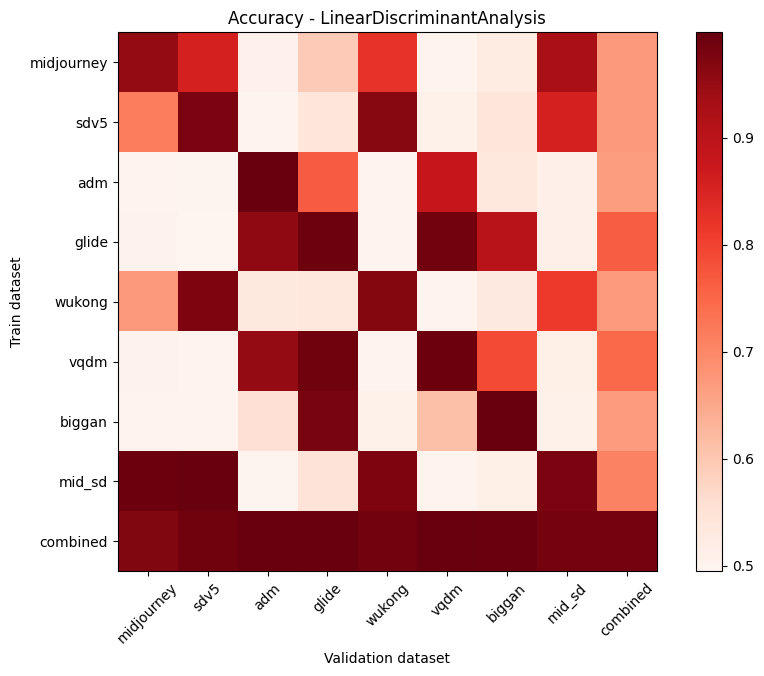

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.95125,0.85625,0.50625,0.59375,0.82375,0.50250,0.52250,0.926875,0.672500
sdv5,0.71625,0.97750,0.50250,0.53875,0.96500,0.50750,0.53875,0.856875,0.673036
adm,0.50125,0.49875,0.99875,0.76500,0.50000,0.88000,0.53500,0.511875,0.667857
glide,0.50375,0.49500,0.95625,0.99000,0.50000,0.98625,0.90625,0.512500,0.763393
wukong,0.67250,0.97375,0.53125,0.53625,0.96750,0.50125,0.52875,0.811875,0.671607
vqdm,0.50375,0.50000,0.95000,0.98875,0.50000,0.99250,0.78875,0.513125,0.748571
biggan,0.50000,0.50125,0.55250,0.98000,0.50875,0.61125,0.99750,0.508125,0.668929
mid_sd,0.99125,0.99500,0.49750,0.54500,0.97500,0.50250,0.51375,0.978125,0.708393
combined,0.97250,0.98750,0.99750,0.99500,0.98500,0.99875,0.99375,0.983750,0.983571


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.95125,0.85625,0.50625,0.59375,0.82375,0.50250,0.52250,0.926875,0.710391
sdv5,0.71625,0.97750,0.50250,0.53875,0.96500,0.50750,0.53875,0.856875,0.700391
adm,0.50125,0.49875,0.99875,0.76500,0.50000,0.88000,0.53500,0.511875,0.648828
glide,0.50375,0.49500,0.95625,0.99000,0.50000,0.98625,0.90625,0.512500,0.731250
wukong,0.67250,0.97375,0.53125,0.53625,0.96750,0.50125,0.52875,0.811875,0.690391
vqdm,0.50375,0.50000,0.95000,0.98875,0.50000,0.99250,0.78875,0.513125,0.717109
biggan,0.50000,0.50125,0.55250,0.98000,0.50875,0.61125,0.99750,0.508125,0.644922
mid_sd,0.99125,0.99500,0.49750,0.54500,0.97500,0.50250,0.51375,0.978125,0.749766
combined,0.97250,0.98750,0.99750,0.99500,0.98500,0.99875,0.99375,0.983750,0.989219


In [17]:
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy")

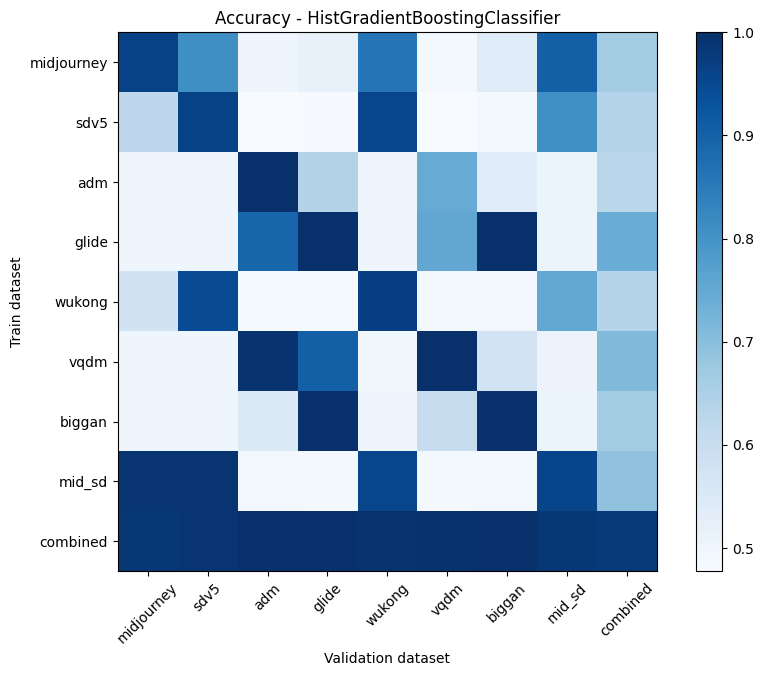

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.96125,0.81000,0.50000,0.51750,0.85750,0.48625,0.53875,0.903750,0.664107
sdv5,0.62125,0.96250,0.47750,0.48000,0.95625,0.47875,0.48625,0.807500,0.637500
adm,0.50000,0.49875,0.99875,0.64250,0.50000,0.74375,0.53750,0.509375,0.627679
glide,0.50125,0.50000,0.89375,0.99875,0.50000,0.75500,0.99750,0.508125,0.742143
wukong,0.57875,0.94375,0.48375,0.48375,0.96875,0.48875,0.49000,0.752500,0.632857
vqdm,0.50000,0.50000,0.99375,0.90375,0.49750,0.99750,0.57500,0.507500,0.711607
biggan,0.50000,0.50000,0.54750,0.99625,0.50000,0.60375,0.99875,0.508125,0.663929
mid_sd,0.99000,0.99125,0.49250,0.48875,0.95625,0.48750,0.49250,0.957500,0.690893
combined,0.98500,0.99125,1.00000,1.00000,0.99250,0.99500,0.99750,0.983750,0.978214


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.96125,0.81000,0.50000,0.51750,0.85750,0.48625,0.53875,0.903750,0.696875
sdv5,0.62125,0.96250,0.47750,0.48000,0.95625,0.47875,0.48625,0.807500,0.658750
adm,0.50000,0.49875,0.99875,0.64250,0.50000,0.74375,0.53750,0.509375,0.616328
glide,0.50125,0.50000,0.89375,0.99875,0.50000,0.75500,0.99750,0.508125,0.706797
wukong,0.57875,0.94375,0.48375,0.48375,0.96875,0.48875,0.49000,0.752500,0.648750
vqdm,0.50000,0.50000,0.99375,0.90375,0.49750,0.99750,0.57500,0.507500,0.684375
biggan,0.50000,0.50000,0.54750,0.99625,0.50000,0.60375,0.99875,0.508125,0.644297
mid_sd,0.99000,0.99125,0.49250,0.48875,0.95625,0.48750,0.49250,0.957500,0.732031
combined,0.98500,0.99125,1.00000,1.00000,0.99250,0.99500,0.99750,0.983750,0.993125


In [18]:
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name="Validation", metric="accuracy")

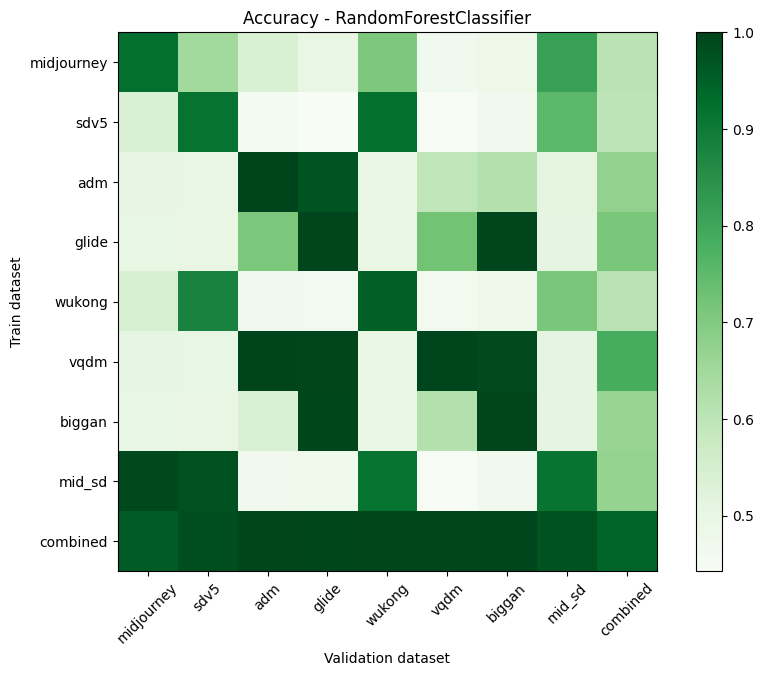

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.92000,0.64875,0.54000,0.50000,0.70625,0.47000,0.48125,0.814375,0.606250
sdv5,0.53625,0.91500,0.45625,0.44250,0.91875,0.44500,0.46500,0.755625,0.599821
adm,0.50375,0.50000,0.99875,0.97000,0.50000,0.59500,0.61875,0.512500,0.673393
glide,0.49875,0.50000,0.71000,0.99750,0.50000,0.72250,0.99750,0.508125,0.711071
wukong,0.54250,0.87875,0.46750,0.46250,0.95000,0.46125,0.47750,0.711875,0.603929
vqdm,0.50250,0.49875,1.00000,0.99625,0.50000,0.99375,0.98875,0.508125,0.783571
biggan,0.49875,0.50000,0.53750,0.99375,0.50000,0.61875,0.99625,0.508125,0.664643
mid_sd,0.99125,0.97750,0.46625,0.47125,0.91500,0.44500,0.46625,0.911250,0.670179
combined,0.96000,0.98250,0.99750,0.99500,0.99625,0.99750,0.99375,0.971875,0.945000


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.92000,0.64875,0.54000,0.50000,0.70625,0.47000,0.48125,0.814375,0.635078
sdv5,0.53625,0.91500,0.45625,0.44250,0.91875,0.44500,0.46500,0.755625,0.616797
adm,0.50375,0.50000,0.99875,0.97000,0.50000,0.59500,0.61875,0.512500,0.649844
glide,0.49875,0.50000,0.71000,0.99750,0.50000,0.72250,0.99750,0.508125,0.679297
wukong,0.54250,0.87875,0.46750,0.46250,0.95000,0.46125,0.47750,0.711875,0.618984
vqdm,0.50250,0.49875,1.00000,0.99625,0.50000,0.99375,0.98875,0.508125,0.748516
biggan,0.49875,0.50000,0.53750,0.99375,0.50000,0.61875,0.99625,0.508125,0.644141
mid_sd,0.99125,0.97750,0.46625,0.47125,0.91500,0.44500,0.46625,0.911250,0.705469
combined,0.96000,0.98250,0.99750,0.99500,0.99625,0.99750,0.99375,0.971875,0.986797


In [19]:
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name="Validation", metric="accuracy")

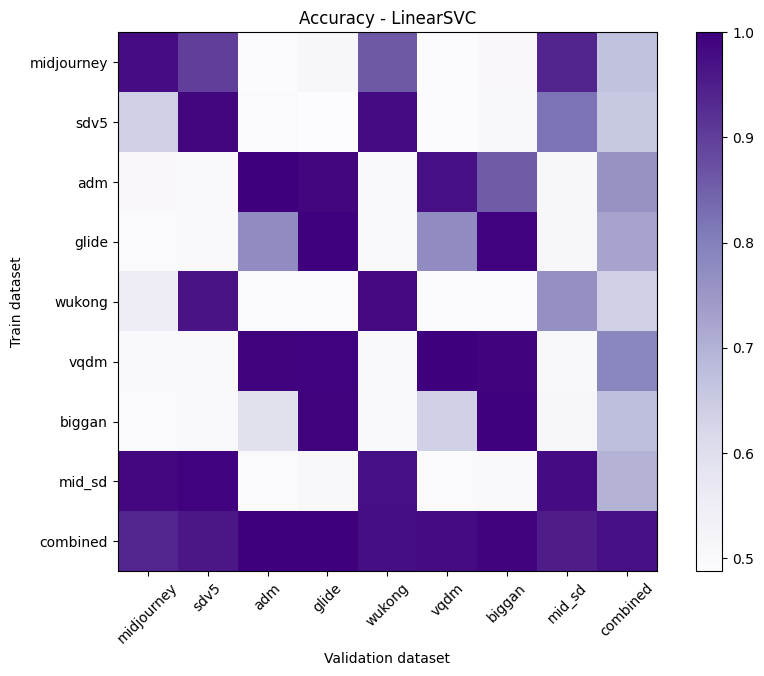

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.97625,0.89875,0.49250,0.50875,0.85875,0.4925,0.50250,0.938750,0.668393
sdv5,0.63875,0.98875,0.49750,0.48750,0.98000,0.4900,0.50375,0.821250,0.654286
adm,0.50250,0.50000,1.00000,0.98875,0.50000,0.9725,0.85750,0.510625,0.761429
glide,0.49750,0.50000,0.77375,0.99625,0.50000,0.7725,0.99500,0.508750,0.725357
wukong,0.55500,0.96625,0.49625,0.49250,0.98250,0.4925,0.49375,0.765000,0.639107
vqdm,0.49875,0.50000,0.99375,0.99500,0.50000,1.0000,0.99000,0.507500,0.785714
biggan,0.49750,0.50000,0.59250,0.99250,0.50000,0.6375,0.99750,0.508125,0.675357
mid_sd,0.98500,0.99500,0.49500,0.50375,0.97250,0.4975,0.50000,0.980625,0.697500
combined,0.93625,0.96125,1.00000,0.99875,0.97500,0.9800,0.99000,0.951875,0.973036


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.97625,0.89875,0.49250,0.50875,0.85875,0.4925,0.50250,0.938750,0.708594
sdv5,0.63875,0.98875,0.49750,0.48750,0.98000,0.4900,0.50375,0.821250,0.675937
adm,0.50250,0.50000,1.00000,0.98875,0.50000,0.9725,0.85750,0.510625,0.728984
glide,0.49750,0.50000,0.77375,0.99625,0.50000,0.7725,0.99500,0.508750,0.692969
wukong,0.55500,0.96625,0.49625,0.49250,0.98250,0.4925,0.49375,0.765000,0.655469
vqdm,0.49875,0.50000,0.99375,0.99500,0.50000,1.0000,0.99000,0.507500,0.748125
biggan,0.49750,0.50000,0.59250,0.99250,0.50000,0.6375,0.99750,0.508125,0.653203
mid_sd,0.98500,0.99500,0.49500,0.50375,0.97250,0.4975,0.50000,0.980625,0.741172
combined,0.93625,0.96125,1.00000,0.99875,0.97500,0.9800,0.99000,0.951875,0.974141


In [20]:
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name="Validation", metric="accuracy")

## Evaluate on test data

In [21]:
X_test = {}
y_test = {}

for key, df in datasets_test.items():
    X_test[key] = df.drop('Category', axis=1)
    y_test[key] = df['Category']

In [22]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for test_dataset_name in X_test.keys():
        print(f"\n\nTest set: {test_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, test_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on biggan. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9920
F1: 0.9920
Precision: 0.9920
Recall: 0.9920
MCC: 0.9840

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Test set: vqdm

Model: HistGradientBoostingClassifier
Accuracy: 0.5940
F1: 0.5139
Precision: 0.7759
Recall: 0.5940
MCC: 0.3221

Model: LinearDiscriminantAnalysis
Accuracy: 0.6150
F1: 0.5504
Precision: 0.7703
Recall: 0.6150
MCC: 0.3526

Model: RandomForestClassifier
Accuracy: 0.6110
F1: 0.5416
Precision: 0.7812
Recall: 0.6110
MCC: 0.3534

Model: LinearSVC
Accuracy: 0.6450
F1: 0.5938
Precision: 0.7924
Recall: 0.6450
MCC: 0.4118


Test set: sdv5

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5010
F1: 0.3408
Precision: 0.5360
Recall: 0.5010
MCC: 0.0120

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5020
F1: 0.3497
Precision: 0.5318
Recall: 0.5020
MCC: 0.0159

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5600
F1: 0.4544
Precision: 0.7660
Recall: 0.5600
MCC: 0.2526

Model: LinearDiscriminantAnalysis
Accuracy: 0.5400
F1: 0.4219
Precision: 0.7188
Recall: 0.5400
MCC: 0.1871

Model: RandomForestClassifier
Accuracy: 0.5400
F1: 0.4165
Precision: 0.7604
Recall: 0.5400
MCC: 0.2041

Model: LinearSVC
Accuracy: 0.6050
F1: 0.5320
Precision: 0.7793
Recall: 0.6050
MCC: 0.3425


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9940
F1: 0.9940
Precision: 0.9941
Recall: 0.9940
MCC: 0.9881

Model: LinearDiscriminantAnalysis
Accuracy: 0.9720
F1: 0.9720
Precision: 0.9723
Recall: 0.9720
MCC: 0.9443

Model: RandomForestClassifier
Accuracy: 0.9940
F1: 0.9940
Precision: 0.9941
Recall: 0.9940
MCC: 0.9881

Model: LinearSVC
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900


Test set: midjourney

Model: HistGradientBoo

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3461
Precision: 0.6798
Recall: 0.5050
MCC: 0.0600

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5030
F1: 0.3434
Precision: 0.6079
Recall: 0.5030
MCC: 0.0360



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6640
F1: 0.6212
Precision: 0.7990
Recall: 0.6640
MCC: 0.4429

Model: LinearDiscriminantAnalysis
Accuracy: 0.6610
F1: 0.6194
Precision: 0.7862
Recall: 0.6610
MCC: 0.4293

Model: RandomForestClassifier
Accuracy: 0.6636
F1: 0.6206
Precision: 0.7989
Recall: 0.6636
MCC: 0.4422

Model: LinearSVC
Accuracy: 0.6779
F1: 0.6406
Precision: 0.8041
Recall: 0.6779
MCC: 0.4651




 *** Evaluating models trained on vqdm. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.5660
F1: 0.4653
Precision: 0.7677
Recall: 0.5660
MCC: 0.2658

Model: LinearDiscriminantAnalysis
Accuracy: 0.8010
F1: 0.7939
Precision: 0.8487
Recall: 0.8010
MCC: 0.6480

Model: RandomForestClassifier
Accuracy: 0.9930
F1: 0.9930
Precision: 0.9931
Recall

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5020
F1: 0.3378
Precision: 0.7505
Recall: 0.5020
MCC: 0.0448

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5030
F1: 0.3451
Precision: 0.5841
Recall: 0.5030
MCC: 0.0318

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.9940
F1: 0.9940
Precision: 0.9940
Recall: 0.9940
MCC: 0.9880

Model: LinearDiscriminantAnalysis
Accuracy: 0.9600
F1: 0.9599
Precision: 0.9627
Recall: 0.9600
MCC: 0.9227

Model: RandomForestClassifier
Accuracy: 0.9990
F1: 0.9990
Precision: 0.9990
Recall: 0.9990
MCC: 0.9980

Model: LinearSVC
Accuracy: 0.9980
F1: 0.9980
Precision: 0.9980
Recall: 0.9980
MCC: 0.9960


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9020
F1: 0.9010
Precision: 0.9181
Recall: 0.9020
MCC: 0.8199

Model: LinearDiscriminantAnalysis
Accuracy: 0.9850
F1: 0.9850
Precision: 0.9851
Recall: 0.9850
MCC: 0.9701

Model: RandomForestClassifier
Accuracy: 0.9980
F1: 0.9980
Precision: 0.9980
Recall: 0.9980
MCC: 0.9960

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Test set: midjourney

Model: HistGradientBoo

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5060
F1: 0.3499
Precision: 0.6515
Recall: 0.5060
MCC: 0.0603

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5010
F1: 0.3356
Precision: 0.7503
Recall: 0.5010
MCC: 0.0316


Test set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5040
F1: 0.3439
Precision: 0.6677
Recall: 0.5040
MCC: 0.0518



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5005
F1: 0.3344
Precision: 0.7501
Recall: 0.5005
MCC: 0.0224


Test set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.7087
F1: 0.6818
Precision: 0.8156
Recall: 0.7087
MCC: 0.5133

Model: LinearDiscriminantAnalysis
Accuracy: 0.7504
F1: 0.7346
Precision: 0.8291
Recall: 0.7504
MCC: 0.5741

Model: RandomForestClassifier
Accuracy: 0.7843
F1: 0.7738
Precision: 0.8491
Recall: 0.7843
MCC: 0.6301

Model: LinearSVC
Accuracy: 0.7843
F1: 0.7738
Precision: 0.8493
Recall: 0.7843
MCC: 0.6302




 *** Evaluating models trained on sdv5. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.4760
F1: 0.3225
Precision: 0.2439
Recall: 0.4760
MCC: -0.1568

Model: LinearDiscriminantAnalysis
Accuracy: 0.5280
F1: 0.4108
Precision: 0.6370
Recall: 0.5280
MCC: 0.1239

Model: RandomForestClassifier
Accuracy: 0.4340
F1: 0.3026
Precision: 0.2323
Recal

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5030
F1: 0.3400
Precision: 0.7508
Recall: 0.5030
MCC: 0.0549

Model: RandomForestClassifier
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3351
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9940
F1: 0.9940
Precision: 0.9940
Recall: 0.9940
MCC: 0.9880

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.6240
F1: 0.5629
Precision: 0.7815
Recall: 0.6240
MCC: 0.3737

Model: LinearDiscriminantAnalysis
Accuracy: 0.7450
F1: 0.7284
Precision: 0.8241
Recall: 0.7450
MCC: 0.5636

Model: RandomForestClassifier
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9762
Recall: 0.9750
MCC: 0.9512

Model: LinearSVC
Accuracy: 0.979

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5030
F1: 0.3400
Precision: 0.7508
Recall: 0.5030
MCC: 0.0549

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4990
F1: 0.3364
Precision: 0.4497
Recall: 0.4990
MCC: -0.0142

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.8900
F1: 0.8887
Precision: 0.9098
Recall: 0.8900
MCC: 0.7996

Model: LinearDiscriminantAnalysis
Accuracy: 0.9490
F1: 0.9489
Precision: 0.9527
Recall: 0.9490
MCC: 0.9017

Model: RandomForestClassifier
Accuracy: 0.7070
F1: 0.6795
Precision: 0.8153
Recall: 0.7070
MCC: 0.5109

Model: LinearSVC
Accuracy: 0.7820
F1: 0.7711
Precision: 0.8482
Recall: 0.7820
MCC: 0.6267


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9940
F1: 0.9940
Precision: 0.9940
Recall: 0.9940
MCC: 0.9880

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 0.9990
F1: 0.9990
Precision: 0.9990
Recall: 0.9990
MCC: 0.9980


Test set: midjourney

Model: HistGradientBoo

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3585
Precision: 0.6811
Recall: 0.5100
MCC: 0.0851

Model: RandomForestClassifier
Accuracy: 0.5010
F1: 0.3356
Precision: 0.7503
Recall: 0.5010
MCC: 0.0316

Model: LinearSVC
Accuracy: 0.5010
F1: 0.3356
Precision: 0.7503
Recall: 0.5010
MCC: 0.0316


Test set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5065
F1: 0.3493
Precision: 0.6928
Recall: 0.5065
MCC: 0.0708

Model: RandomForestClassifier
Accuracy: 0.5005
F1: 0.3344
Precision: 0.7501
Recall: 0.5005
MCC: 0.0224

Model: LinearSVC
Accuracy: 0.5005
F1: 0.3344
Precision: 0.7501
Recall: 0.5005
MCC: 0.0224


Test set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.7339
F1: 0.7136
Precision: 0.8263
Recall: 0.7339
MCC: 0.5525

Model: LinearDiscriminantAnalysis
Accuracy: 0.7640
F1: 0.7506
Precision: 0.8360
Recall: 0.7640
MCC: 0.5956

Model: RandomForestClassifier
Accuracy: 0.7037
F1: 0.6752
Precision: 0.8140
Recall: 0.7037
MCC: 0.5058

Model: LinearSVC
Accuracy: 0.7194
F1: 0.6955
Precision: 0.8203
Recall: 0.7194
MCC: 0.5302




 *** Evaluating models trained on midjourney. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.5280
F1: 0.4209
Precision:

In [23]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="test_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

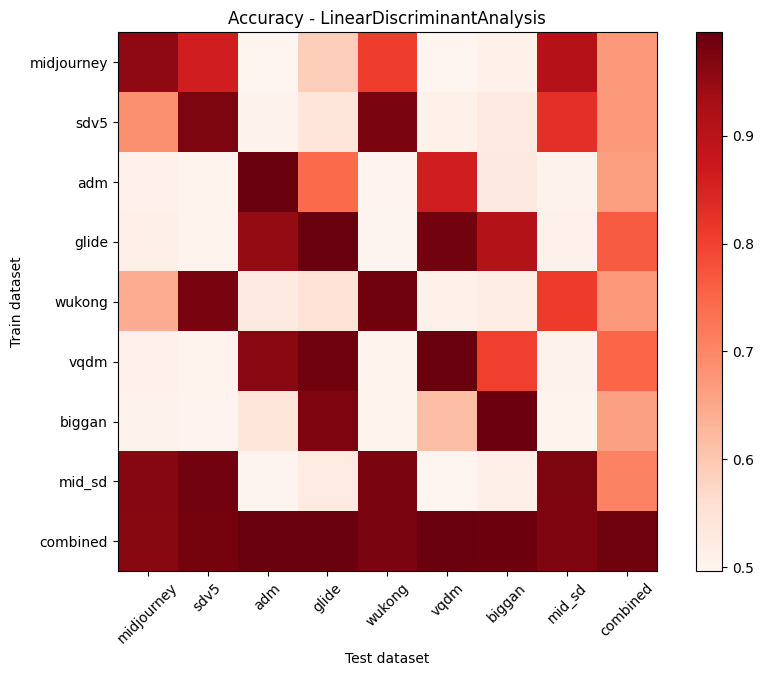

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.954,0.861,0.496,0.588,0.805,0.496,0.509,0.9075,0.672714
sdv5,0.686,0.973,0.504,0.539,0.976,0.508,0.528,0.8295,0.673429
adm,0.506,0.503,0.994,0.745,0.500,0.861,0.530,0.5045,0.662714
glide,0.510,0.503,0.949,0.994,0.499,0.984,0.909,0.5065,0.764000
wukong,0.642,0.977,0.529,0.549,0.985,0.509,0.521,0.8095,0.673143
vqdm,0.506,0.502,0.960,0.985,0.503,0.996,0.801,0.5040,0.750429
biggan,0.505,0.501,0.540,0.972,0.502,0.615,0.992,0.5030,0.661000
mid_sd,0.963,0.984,0.499,0.527,0.975,0.497,0.512,0.9735,0.708143
combined,0.961,0.981,0.995,0.993,0.976,0.994,0.990,0.9710,0.984286


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.954,0.861,0.496,0.588,0.805,0.496,0.509,0.9075,0.702063
sdv5,0.686,0.973,0.504,0.539,0.976,0.508,0.528,0.8295,0.692937
adm,0.506,0.503,0.994,0.745,0.500,0.861,0.530,0.5045,0.642937
glide,0.510,0.503,0.949,0.994,0.499,0.984,0.909,0.5065,0.731812
wukong,0.642,0.977,0.529,0.549,0.985,0.509,0.521,0.8095,0.690187
vqdm,0.506,0.502,0.960,0.985,0.503,0.996,0.801,0.5040,0.719625
biggan,0.505,0.501,0.540,0.972,0.502,0.615,0.992,0.5030,0.641250
mid_sd,0.963,0.984,0.499,0.527,0.975,0.497,0.512,0.9735,0.741313
combined,0.961,0.981,0.995,0.993,0.976,0.994,0.990,0.9710,0.982625


In [24]:
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Test", metric="accuracy")

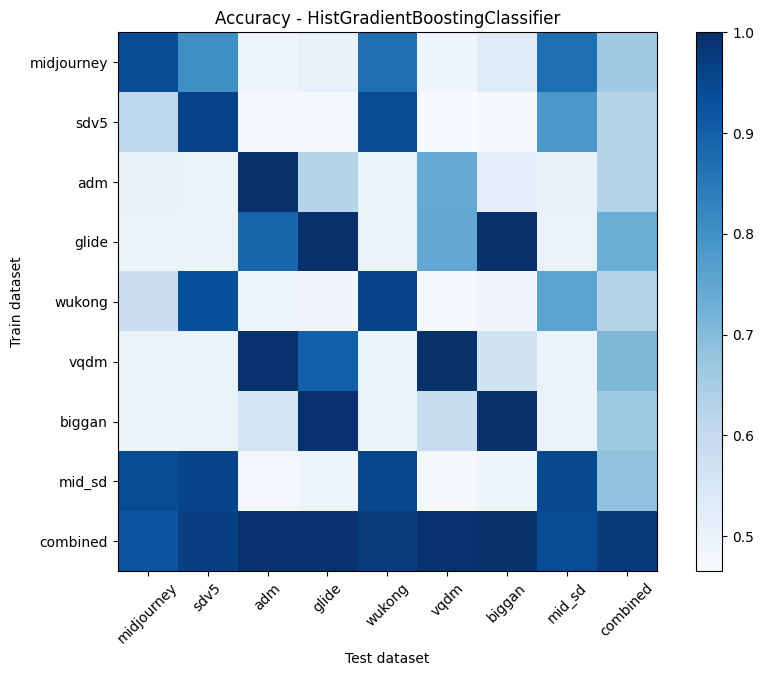

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.939,0.805,0.492,0.504,0.872,0.486,0.528,0.8720,0.660857
sdv5,0.609,0.961,0.477,0.474,0.943,0.465,0.476,0.7850,0.629286
adm,0.502,0.500,1.000,0.624,0.500,0.741,0.517,0.5010,0.626286
glide,0.500,0.500,0.890,1.000,0.500,0.747,1.000,0.5000,0.733857
wukong,0.580,0.934,0.486,0.483,0.957,0.476,0.482,0.7570,0.628286
vqdm,0.500,0.500,0.994,0.902,0.500,0.999,0.566,0.5000,0.708714
biggan,0.500,0.500,0.560,0.994,0.500,0.594,1.000,0.5000,0.664000
mid_sd,0.940,0.957,0.481,0.492,0.954,0.475,0.486,0.9485,0.683571
combined,0.921,0.966,0.994,0.995,0.974,0.995,0.996,0.9435,0.977286


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.939,0.805,0.492,0.504,0.872,0.486,0.528,0.8720,0.687250
sdv5,0.609,0.961,0.477,0.474,0.943,0.465,0.476,0.7850,0.648750
adm,0.502,0.500,1.000,0.624,0.500,0.741,0.517,0.5010,0.610625
glide,0.500,0.500,0.890,1.000,0.500,0.747,1.000,0.5000,0.704625
wukong,0.580,0.934,0.486,0.483,0.957,0.476,0.482,0.7570,0.644375
vqdm,0.500,0.500,0.994,0.902,0.500,0.999,0.566,0.5000,0.682625
biggan,0.500,0.500,0.560,0.994,0.500,0.594,1.000,0.5000,0.643500
mid_sd,0.940,0.957,0.481,0.492,0.954,0.475,0.486,0.9485,0.716687
combined,0.921,0.966,0.994,0.995,0.974,0.995,0.996,0.9435,0.973062


In [25]:
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name="Test", metric="accuracy")

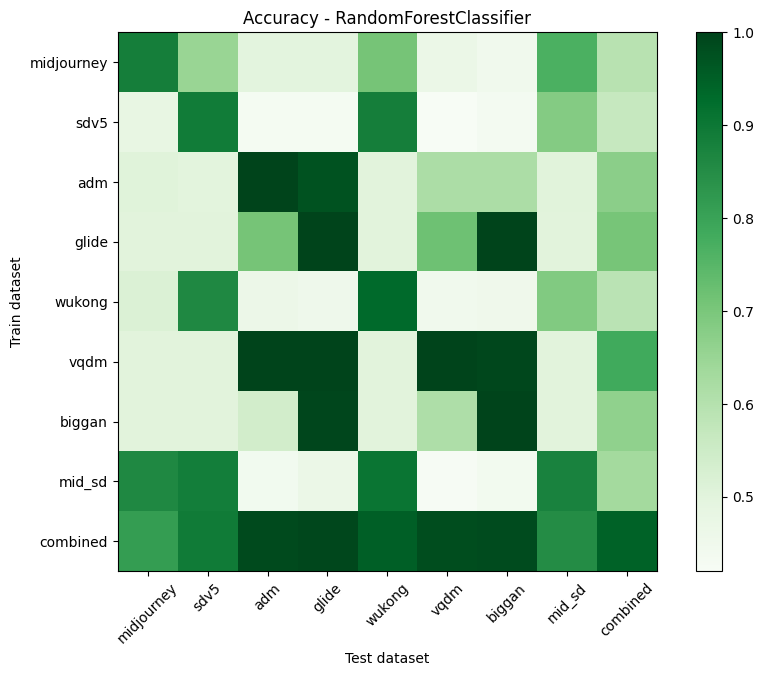

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.883,0.651,0.496,0.497,0.706,0.468,0.447,0.7670,0.592571
sdv5,0.479,0.889,0.431,0.431,0.883,0.420,0.434,0.6840,0.566714
adm,0.505,0.499,1.000,0.975,0.500,0.617,0.615,0.5020,0.673000
glide,0.501,0.500,0.707,1.000,0.500,0.718,1.000,0.5005,0.703714
wukong,0.516,0.861,0.465,0.455,0.930,0.447,0.452,0.6885,0.589429
vqdm,0.500,0.500,0.999,0.998,0.500,1.000,0.993,0.5000,0.784286
biggan,0.500,0.500,0.540,0.994,0.500,0.611,1.000,0.5000,0.663571
mid_sd,0.861,0.886,0.442,0.468,0.906,0.424,0.440,0.8735,0.632429
combined,0.812,0.892,0.988,0.991,0.951,0.984,0.986,0.8520,0.943429


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.883,0.651,0.496,0.497,0.706,0.468,0.447,0.7670,0.614375
sdv5,0.479,0.889,0.431,0.431,0.883,0.420,0.434,0.6840,0.581375
adm,0.505,0.499,1.000,0.975,0.500,0.617,0.615,0.5020,0.651625
glide,0.501,0.500,0.707,1.000,0.500,0.718,1.000,0.5005,0.678312
wukong,0.516,0.861,0.465,0.455,0.930,0.447,0.452,0.6885,0.601813
vqdm,0.500,0.500,0.999,0.998,0.500,1.000,0.993,0.5000,0.748750
biggan,0.500,0.500,0.540,0.994,0.500,0.611,1.000,0.5000,0.643125
mid_sd,0.861,0.886,0.442,0.468,0.906,0.424,0.440,0.8735,0.662563
combined,0.812,0.892,0.988,0.991,0.951,0.984,0.986,0.8520,0.932000


In [26]:
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name="Test", metric="accuracy")

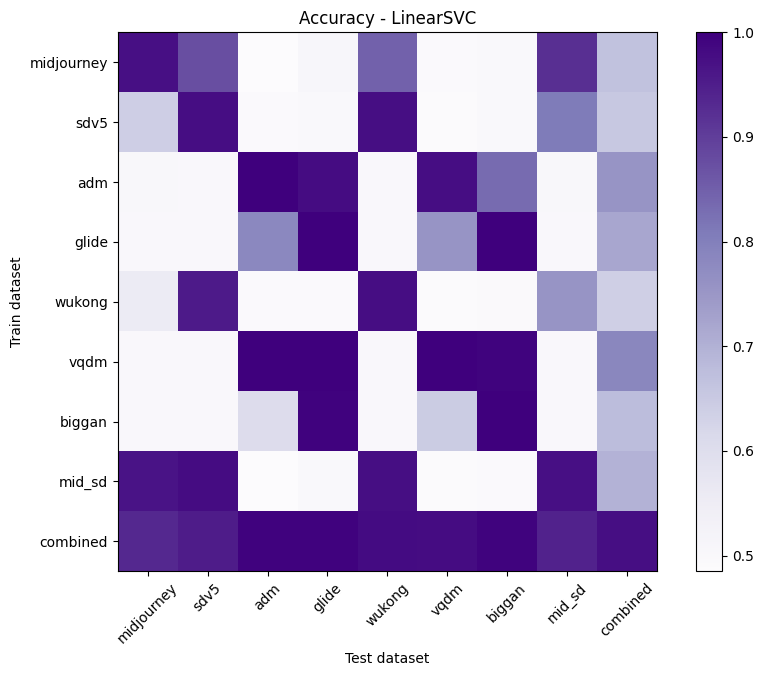

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.973,0.874,0.486,0.506,0.846,0.492,0.499,0.9235,0.668000
sdv5,0.639,0.977,0.493,0.496,0.975,0.488,0.496,0.8080,0.652000
adm,0.505,0.500,1.000,0.979,0.500,0.976,0.833,0.5025,0.756143
glide,0.501,0.500,0.782,0.999,0.500,0.755,0.999,0.5005,0.719429
wukong,0.557,0.954,0.493,0.492,0.977,0.489,0.495,0.7555,0.636714
vqdm,0.501,0.500,0.998,1.000,0.500,0.999,0.992,0.5005,0.784286
biggan,0.500,0.500,0.605,0.995,0.500,0.645,1.000,0.5000,0.677857
mid_sd,0.966,0.978,0.485,0.496,0.975,0.490,0.492,0.9720,0.697429
combined,0.932,0.952,0.994,0.995,0.980,0.979,0.993,0.9420,0.975000


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.973,0.874,0.486,0.506,0.846,0.492,0.499,0.9235,0.699937
sdv5,0.639,0.977,0.493,0.496,0.975,0.488,0.496,0.8080,0.671500
adm,0.505,0.500,1.000,0.979,0.500,0.976,0.833,0.5025,0.724437
glide,0.501,0.500,0.782,0.999,0.500,0.755,0.999,0.5005,0.692063
wukong,0.557,0.954,0.493,0.492,0.977,0.489,0.495,0.7555,0.651563
vqdm,0.501,0.500,0.998,1.000,0.500,0.999,0.992,0.5005,0.748812
biggan,0.500,0.500,0.605,0.995,0.500,0.645,1.000,0.5000,0.655625
mid_sd,0.966,0.978,0.485,0.496,0.975,0.490,0.492,0.9720,0.731750
combined,0.932,0.952,0.994,0.995,0.980,0.979,0.993,0.9420,0.970875


In [27]:
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name="Test", metric="accuracy")

## Save models and scalers

In [28]:
# for each dataset save models and scalers
import joblib

for dataset_name in models.keys():
    for model_name, model in models[dataset_name].items():
        models_dir_path = f"models/GenImage512x512/standard/{dataset_name}"
        scalers_dir_path = f"scalers/GenImage512x512/standard/{dataset_name}"
        os.makedirs(models_dir_path, exist_ok=True)
        os.makedirs(scalers_dir_path, exist_ok=True)
        joblib.dump(model, os.path.join(models_dir_path, f"{dataset_name}_{model_name}.joblib"))
        joblib.dump(scalers[dataset_name], os.path.join(scalers_dir_path, f"{dataset_name}_{model_name}.joblib"))